In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import psycopg2

In [13]:
def GMM(dat, k, param1, param2):
    if k == 1:
        p_class_given_data = np.ones((len(dat), 1))
        means = np.array([np.mean(dat.loc[:, param1]), np.mean(dat.loc[:, param2])])
        covars = np.cov(np.transpose(dat))
        p_class = np.array([1])

        p_sum = 0
        for i in range(len(dat)):
            p_sum += p_class_given_data[i][0]*(np.square(dat.iloc[i].values-means[0]))
        mean_dist = np.sqrt(p_sum / len(dat.index))
        return p_class_given_data, means, covars, p_class, mean_dist

    """Define the variables we will use in the Algorithm"""
    #This represents Σ_m (covariance matrix of each component) (slide 26)
    covars=np.zeros((k,2,2))

    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,2))

    #This represents W_m (weights/likelihood of each component) (slide 26 bottom)
    p_class=np.zeros(k)

    #This represents P(x_i | cluster = m), or Φ(x_i | μ_m, Σ_m) (slide 27)
    #During the Expectation step, we will use this to derive p̂_mi (or p_class_given_data) as shown on slide 27
    #p_class_given_data will be the same shape
    p_data_given_class=np.zeros((len(dat),k))
    p_class_given_data=np.zeros((len(dat),k))


    """Initialize means, covs, p_classes"""
    #initializations of starting points (used to set the initial means below)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)

    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        covars[dim,:,:]=np.cov(np.transpose(dat))

        #Set initial means to initial chosen data points (slide 26)
        means[dim,:]=dat.iloc[init_idx[dim]]

        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k

    """Now Iterate"""
    #Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    #Note - 50 steps is fine, no requirement to check for convergence on this HW

    for step in range(50):
        """Expectation Step (Slide 27)"""
        for row_i in range(len(dat.index)):
            for component in range(k):
                p_data_given_class[row_i][component] = stats.multivariate_normal(means[component], covars[component]).cdf(dat.iloc[row_i].values.tolist())*p_class[component]
            for component in range(k):
                p_class_given_data[row_i][component] = p_data_given_class[row_i][component]/sum(p_data_given_class[row_i])
        """Maximization Step (Slide 29-30)"""
        for component in range(k):
            n_m = sum(p_class_given_data[:, component])
            p_class[component] = n_m/len(dat.index)
            weighted_values = [[p_class_given_data[idx_x][component]*dat.iloc[idx_x][param1], p_class_given_data[idx_x][component]*dat.iloc[idx_x][param2]] for idx_x in range(len(dat.index))]
            means[component, :] = list(np.sum(weighted_values, axis=0) / n_m)

            covar = [[0, 0],[0, 0]]
            x = dat.loc[:, param1]
            y = dat.loc[:, param2]
            for i in range(k):
                covar[0][0] += (x[i]-means[component][0])*(x[i]-means[component][0])
                covar[0][1] += (x[i]-means[component][0])*(y[i]-means[component][1])
                covar[1][0] += (y[i]-means[component][1])*(x[i]-means[component][0])
                covar[1][1] += (y[i]-means[component][1])*(y[i]-means[component][1])

            covars[component, :, :] = list(np.array(covar)/n_m)
    mean_dist = 0
    """Once we're done with our for loop, we compute the mean dist (This formula is given in the HW below in Part B)"""

    p_sum = 0
    for i in range(len(dat.index)):
        for component in range(k):
            p_sum += p_class_given_data[i][component]*(np.square(dat.iloc[i].values-means[component]))
    mean_dist = np.sqrt(p_sum / len(dat.index))
    return p_class_given_data, means, covars, p_class, mean_dist

In [14]:
conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432",
)
cur = conn.cursor()
cur.execute("SELECT * FROM machine_links INNER JOIN features ON machine_links.ccn = features.ccn") # query to get joined data
res = cur.fetchall()
df = pd.DataFrame(res)

df = df.iloc[:, 0:9] # remove the double ccn column
df.columns = ["ccn", "state_or_region", "reporting_entity_name_common", "machine_readable_url",'csv_headers','meets_standards' ,"bed_count", "zip_code", "medicare_medicaid_eligible"]

df.set_index("ccn", inplace=True) # index by ccn
df_zip = df.filter(['meets_standards','zip_code'])
df_zip.meets_standards = df_zip.meets_standards.replace({True: 1, False: 0})
df_bed  = df.filter(['meets_standards','bed_count'])
df_bed.meets_standards = df_bed.meets_standards.replace({True: 1, False: 0})
df_medicare = df.filter(['meets_standards','medicare_medicaid_eligible'])
df_medicare.meets_standards = df_medicare.meets_standards.replace({True: 1, False: 0})
df_medicare.medicare_medicaid_eligible = df_medicare.medicare_medicaid_eligible.replace({True: 1, False: 0})


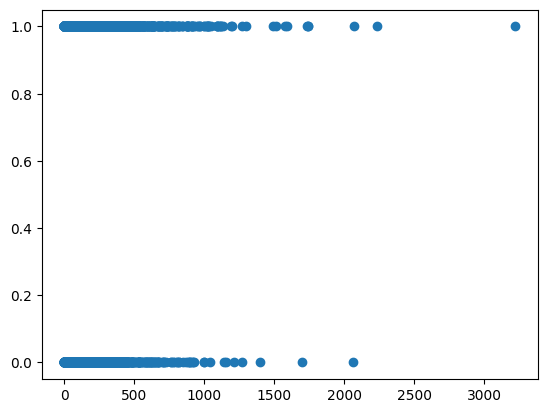

In [15]:
plt.scatter(df_bed.bed_count, df_zip.meets_standards)
plt.show()

In [16]:
GMM(df_bed, 3, "meets_standards", "bed_count")

(array([[1.00000000e+000, 3.12509458e-133, 1.62288075e-146],
        [2.26745001e-010, 9.99999997e-001, 2.86999203e-009],
        [1.00000000e+000, 1.06320062e-132, 3.11919101e-295],
        ...,
        [3.99410090e-009, 9.99999996e-001, 0.00000000e+000],
        [3.99410090e-009, 9.99999996e-001, 0.00000000e+000],
        [3.99410090e-009, 9.99999996e-001, 0.00000000e+000]]),
 array([[1.16214418e-01, 1.52121065e+02],
        [1.00000000e+00, 1.57684845e+02],
        [1.00000000e+00, 4.97262339e+02]]),
 array([[[ 6.63116991e-04,  2.04599472e-02],
         [ 2.04599472e-02,  9.35752578e+01]],
 
        [[ 9.21284507e-04, -2.03894224e-01],
         [-2.03894224e-01,  4.97947738e+01]],
 
        [[ 1.49816578e-02,  1.77176589e+00],
         [ 1.77176589e+00,  7.30489698e+02]]]),
 array([0.34590445, 0.61620268, 0.03789287]),
 array([1.88487058e-01, 2.14283077e+02]))